In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = 0.01  # flat‐zone threshold for returns
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats        = len(params.features_cols_tick),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT'],
    conv_k         = params.hparams['CONV_K'],
    conv_dilation  = params.hparams['CONV_DILATION'],
    smooth_k         = params.hparams['SMOOTH_K'],
    smooth_dilation  = params.hparams['SMOOTH_DILATION']
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.05, inplace=False)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (short2long): Linear(in_features=96, out_features=128, bias=True)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
  (smoother): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,), bias

In [6]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 1e-05
)

In [7]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



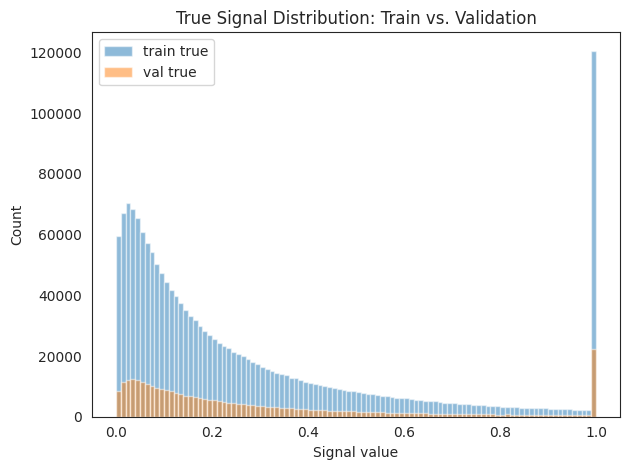

In [8]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'SHORT_UNITS': 96, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.05, 'DROPOUT_LONG': 0.1, 'ATT_HEADS': 6, 'ATT_DROPOUT': 0.0, 'WEIGHT_DECAY': 1e-05, 'CONV_K': 3, 'CONV_DILATION': 1, 'SMOOTH_K': 5, 'SMOOTH_DILATION': 2, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'LR_EPOCHS_WARMUP': 3, 'INITIAL_LR': 5e-05, 'CLIPNORM': 0.5, 'ETA_MIN': 1e-06, 'T_0': 100, 'T_MULT': 1, 'DIFF1_WEIGHT': 1.0, 'DIFF2_WEIGHT': 0.2, 'SMOOTH_ALPHA': 0.005, 'SMOOTH_BETA': 20.0, 'SMOOTH_DELTA': 0.01, 'HUBER_BETA': 0.1, 'CLS_LOSS_WEIGHT': 0.05, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


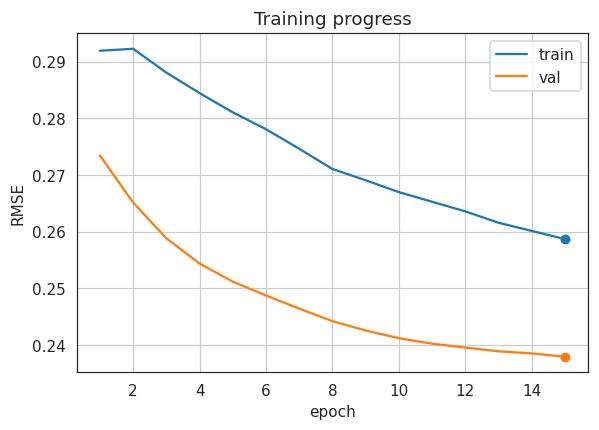

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.29191 MAE=0.24406 R2=-0.00992 | Acc=0.89453 Prec=0.12500 Rec=0.00251 F1=0.00491 AUROC=0.55196
VALID→ RMSE=0.27342 MAE=0.20523 R2=0.09247 | Acc=0.71215 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.65007


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.29226 MAE=0.24514 R2=-0.01233 | Acc=0.89609 Prec=0.50000 Rec=0.00752 F1=0.01481 AUROC=0.54996
VALID→ RMSE=0.26511 MAE=0.19827 R2=0.14677 | Acc=0.71196 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.67580


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28805 MAE=0.24116 R2=0.01657 | Acc=0.89609 Prec=0.50000 Rec=0.01253 F1=0.02445 AUROC=0.64380
VALID→ RMSE=0.25880 MAE=0.19516 R2=0.18691 | Acc=0.71183 Prec=0.01629 Rec=0.00005 F1=0.00010 AUROC=0.69461


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.28444 MAE=0.23884 R2=0.04112 | Acc=0.89661 Prec=0.54545 Rec=0.03008 F1=0.05701 AUROC=0.68828
VALID→ RMSE=0.25435 MAE=0.19312 R2=0.21462 | Acc=0.71188 Prec=0.20954 Rec=0.00104 F1=0.00207 AUROC=0.70782


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.28104 MAE=0.23666 R2=0.06389 | Acc=0.89505 Prec=0.47297 Rec=0.08772 F1=0.14799 AUROC=0.73496
VALID→ RMSE=0.25115 MAE=0.19167 R2=0.23427 | Acc=0.71284 Prec=0.52348 Rec=0.00538 F1=0.01066 AUROC=0.71692


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.27806 MAE=0.23477 R2=0.08362 | Acc=0.89427 Prec=0.47107 Rec=0.14286 F1=0.21923 AUROC=0.77368
VALID→ RMSE=0.24871 MAE=0.19108 R2=0.24907 | Acc=0.71630 Prec=0.72572 Rec=0.02012 F1=0.03916 AUROC=0.72347


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.27461 MAE=0.23233 R2=0.10622 | Acc=0.89297 Prec=0.47115 Rec=0.24561 F1=0.32290 AUROC=0.79981
VALID→ RMSE=0.24639 MAE=0.19088 R2=0.26301 | Acc=0.72120 Prec=0.77136 Rec=0.04202 F1=0.07970 AUROC=0.72845


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.27104 MAE=0.22968 R2=0.12932 | Acc=0.89635 Prec=0.50177 Rec=0.35589 F1=0.41642 AUROC=0.81934
VALID→ RMSE=0.24418 MAE=0.19069 R2=0.27617 | Acc=0.72595 Prec=0.77555 Rec=0.06488 F1=0.11974 AUROC=0.73214


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26905 MAE=0.22873 R2=0.14206 | Acc=0.89948 Prec=0.52025 Rec=0.41855 F1=0.46389 AUROC=0.84255
VALID→ RMSE=0.24253 MAE=0.19056 R2=0.28594 | Acc=0.72986 Prec=0.77197 Rec=0.08475 F1=0.15273 AUROC=0.73501


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.26696 MAE=0.22737 R2=0.15533 | Acc=0.89245 Prec=0.48293 Rec=0.49624 F1=0.48949 AUROC=0.84498
VALID→ RMSE=0.24118 MAE=0.19055 R2=0.29390 | Acc=0.73320 Prec=0.76537 Rec=0.10288 F1=0.18138 AUROC=0.73740


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.26526 MAE=0.22614 R2=0.16607 | Acc=0.89193 Prec=0.48238 Rec=0.54887 F1=0.51348 AUROC=0.86793
VALID→ RMSE=0.24021 MAE=0.19095 R2=0.29956 | Acc=0.73611 Prec=0.75750 Rec=0.11984 F1=0.20694 AUROC=0.73917


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.26356 MAE=0.22461 R2=0.17670 | Acc=0.88854 Prec=0.47082 Rec=0.58647 F1=0.52232 AUROC=0.87680
VALID→ RMSE=0.23951 MAE=0.19126 R2=0.30361 | Acc=0.73814 Prec=0.75273 Rec=0.13186 F1=0.22441 AUROC=0.74088


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.26155 MAE=0.22244 R2=0.18920 | Acc=0.88958 Prec=0.47637 Rec=0.63158 F1=0.54310 AUROC=0.88449
VALID→ RMSE=0.23886 MAE=0.19154 R2=0.30739 | Acc=0.73969 Prec=0.74861 Rec=0.14145 F1=0.23794 AUROC=0.74187


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.26011 MAE=0.22110 R2=0.19810 | Acc=0.88750 Prec=0.47005 Rec=0.64912 F1=0.54526 AUROC=0.88768
VALID→ RMSE=0.23849 MAE=0.19195 R2=0.30952 | Acc=0.74109 Prec=0.74166 Rec=0.15164 F1=0.25180 AUROC=0.74220


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.25867 MAE=0.21970 R2=0.20699 | Acc=0.88828 Prec=0.47312 Rec=0.66165 F1=0.55172 AUROC=0.89582
VALID→ RMSE=0.23789 MAE=0.19116 R2=0.31300 | Acc=0.74225 Prec=0.73833 Rec=0.15931 F1=0.26207 AUROC=0.74243


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

In [ ]:
importlib.reload(params.model_selected) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device,
    cls_loss_weight     = params.hparams['CLS_LOSS_WEIGHT'],
    smooth_alpha        = params.hparams['SMOOTH_ALPHA'],
    smooth_beta         = params.hparams['SMOOTH_BETA'],
    smooth_delta        = params.hparams['SMOOTH_DELTA'],
    diff1_weight        = params.hparams['DIFF1_WEIGHT'],
    diff2_weight        = params.hparams['DIFF2_WEIGHT'],
)


In [ ]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")
